# Data Exploration and Cleaning

__Project Goal__

Compare recipes from two popular recipe websites, Spoonacular and Food.com, and identify "healthy" recipes using two market-implemented measures: Nutri-Scores and Weight Watchers (WW) Smart Points. The project will investigate recipe popularity, meal types, and cuisines.

__Scope__
* Nutritional values of interest: `calories`, `saturated fat`, `sugar`, and `protein`.
* Meal types: `breakfast`, `lunch`, and `dinner`.
* Cuisines

__Research Questions__
1. Are more popular / higher-rated recipes healthier? What is the health rating of the highest-rated recipes?
2. What meal type (i.e., breakfast, lunch, or dinner) have the healthiest / unhealthiest (percentage) recipes? What is the most popular ingredient for each meal?
3. Which cuisine has the healthiest recipes?

# Setup
This section contains the library imports and functions used throughout the project.

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import requests
import scipy.stats as stats

# Import API keys
from alyssa_config import spoonacular_key, rapidapi_key
# from lakna_config import spoonacular_key

In [2]:
# Check number of items in the Resources subdirectories
# Purpose: Automate file naming
def recipe_folder():
    count = len(os.listdir('Resources/01_recipe_IDs'))-1
    return(count)

def raw_folder():
    count = len(os.listdir('Resources/02_raw_data'))-1
    return(count)

def simple_folder():
    count = len(os.listdir('Resources/03_simplified_data'))-1
    return(count)

def complex_folder():
    count = len(os.listdir('Resources/04_complex_test'))-1
    return(count)

In [3]:
# Purpose: Check each value in a list whether it exists in the tags
def tag_check(input_list):
    yes_tag = []
    not_tag = []
    alt_tag = []

    # Loop through each tag in the list
    for tag in input_list:
        if tag in unique_tags:
            yes_tag.append(tag)
        else:
            not_tag.append(tag)
            # Check for alternative tags
            for values in unique_tags:
                if tag in values:
                    alt_tag.append(values)
    return([yes_tag, not_tag, alt_tag])

In [4]:
# Purpose: Get a count of a given list from the tags column, and return its id
def parse_tags(input_list, df, save_col):
    # Create a dictionary to hold the count and list of IDs
    word_dict = {}
    for word in input_list:
        word_dict[word] = dict(count = 0, id_list = [])

    # Add a `multiple` key to track mutual exclusivity
    word_dict['multiple'] = dict(count = 0, id_list = [])

    for df_idx, string in df.iterrows():
        tag_list = string['tags'].strip("[]").split(', ')
    
        # Track mutual exclusivity for the meal types
        score = 0
        for word_idx in range(len(tag_list)):
            # Check the tag
            tag = tag_list[word_idx].strip("'")
            if tag in input_list:
                word_dict[tag]['count'] += 1
                word_dict[tag]['id_list'].append(string[save_col])
                score += 1
                # If >1 tag in a list, add to 'multiple' and continue
                if (score > 1):
                    word_dict['multiple']['count'] += 1
                    word_dict['multiple']['id_list'].append(string[save_col])
                    continue
    return(word_dict)

In [155]:
# Define a function to create linear regression plots
def linreg_plot(ax_object, x_values, y_values, x_coord, y_coord):
    # Calculate the lienar regression for x- and y-values
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

    # Get regression values and equation
    regression_values = x_values * slope + intercept
    line_equation = f'y = {round(slope, 2)}x + {round(intercept, 2)}'

    # Calculate the r-value
    print(f'The r-value is: {rvalue**2}')

    # Plot the linear regression
    ax_object.plot(x_values, regression_values, color='red')
    ax_object.annotate(
        line_equation, xy=(x_coord, y_coord), xycoords='figure points',
        fontsize = 15, color='red', weight='bold')
    plt.show()

# Data Exploration - Food.com

__Goal__
* Identify dataset format and required attributes.
* Extract required attributes.

__Datasets__
1. `RAW_recipes.csv`
2. `RAW_interactions.csv`

In [6]:
# Import the FOOD.COM datasets as DataFrames.
food_df = pd.read_csv('Resources/RAW_recipes.csv')
interactions_df = pd.read_csv('Resources/RAW_interactions.csv')

## Data Format and Attributes

In [7]:
# Display the DataFrame
food_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [8]:
# Display the DataFrame
interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [9]:
# Get the DataFrame dimensions
interactions_shape = interactions_df.shape
food_shape = food_df.shape

# Print findings
hash = f'{8*"#"}'
print(f'{hash} Shape {hash}')
print(f"food_df: {food_shape}")
print(f"interactions_df: {interactions_shape}")

# Get the columns
print(f'\n{hash} Columns {hash}')
print(f'food_df: {food_df.columns}')
print(f'interactions_df: {interactions_df.columns}')

# Get the datatypes
print(f'\n{hash} Data Types {hash}')
print(f'food_df: {food_df.dtypes}')
print(f'\ninteractions_df: {interactions_df.dtypes}')

######## Shape ########
food_df: (231637, 12)
interactions_df: (1132367, 5)

######## Columns ########
food_df: Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')
interactions_df: Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

######## Data Types ########
food_df: name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

interactions_df: user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


## Extract Ratings from interactions_df

In [10]:
# Check how many recipes have ratings
unique_ratings = len(interactions_df['recipe_id'].unique())

# Check how many recipes have a '0' rating
zero_rating_df = interactions_df.loc[interactions_df['rating'] == 0]['recipe_id'].unique()

# Drop the rows with a '0' rating
nonzero_df = interactions_df.loc[interactions_df['rating'] != 0]
nonzero_shape = nonzero_df.shape

# Print findings
print(f'Recipes with ratings: {unique_ratings} out of {food_shape[0]}')
print(f'Recipes with a "0" rating: {zero_rating_df.shape[0]}')
print(f'Updated shape: {nonzero_shape}')

Recipes with ratings: 231637 out of 231637
Recipes with a "0" rating: 35114
Updated shape: (1071520, 5)


In [11]:
# Create a DataFrame with the average ratings per recipe ID
food_ratings = nonzero_df.groupby('recipe_id')['rating'].mean().reset_index()

# Display the DataFrame
food_ratings.head()

,recipe_id,rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000


In [12]:
# Rename the recipe ID column for merging with food_df
food_ratings = food_ratings.rename(columns={'recipe_id': 'id'})

# Merge the datasets and display updated DataFrame
merged_food = pd.merge(food_df, food_ratings, on='id')

# Confirm the row dimensions, to ensure correct merge
merged_shape = merged_food.shape
print(f'food_ratings rows: {food_ratings.shape[0]}')
print(f'merged_food rows: {merged_shape[0]}')

# Display the DataFrame
merged_food.head()

food_ratings rows: 226590
merged_food rows: 226590


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


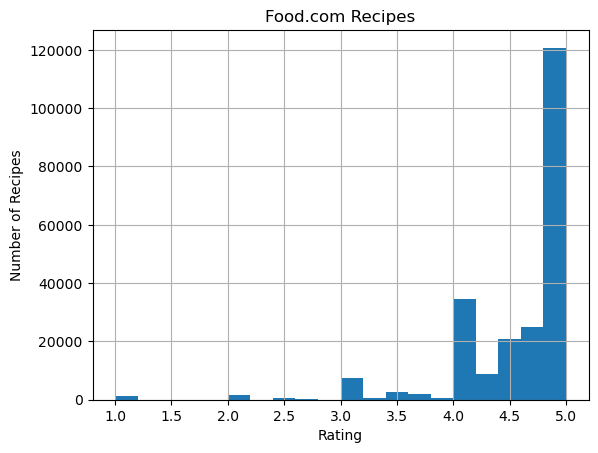

In [211]:
# Create a histogram of the ratings
merged_food['rating'].hist(bins=20)
plt.title("Food.com Recipes")
plt.xlabel("Rating")
plt.ylabel("Number of Recipes")
plt.show()

## Check for duplicate recipe IDs

In [14]:
# Determine whether there are duplicate recipes by ID
dup_id = len(merged_food['id'].unique())
print(f'Unique recipe IDs: {dup_id} of {merged_shape[0]}')

# Determine whether there are duplicate recipes by name
dup_name = len(merged_food['name'].unique())
print(f'Unique recipe names: {dup_name} of {merged_shape[0]}')

# Get the duplicate names - remove to simplify the dataset
duplicate_names = merged_food.loc[merged_food.duplicated(['name'])]
dupname_shape = duplicate_names.shape
print(f'Number of duplicate rows to remove: {dupname_shape[0]}')

# Create a new DataFrame without the duplicates
updated_food = merged_food.loc[~merged_food.duplicated(['name'])].copy()
updated_shape = updated_food.shape
print(f'updated_food rows: {updated_shape[0]}')

Unique recipe IDs: 226590 of 226590
Unique recipe names: 225190 of 226590
Number of duplicate rows to remove: 1400
updated_food rows: 225190


In [15]:
# Display the DataFrame
updated_food.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


## Parse the `tags` column
* Extract meal types.
* Extract cuisines.

In [16]:
# Identify how to isolate each tag
tag_string = updated_food['tags'][0].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_tags = []
for string in updated_food['tags']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_tags:
            unique_tags.append(tag)

# Display the tags alphabetically
print(f"Number of unique tags: {len(unique_tags)}")
sorted(unique_tags)

Number of unique tags: 547


['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 'breakfast-casserole

### Extract meal types
* Meal types of interest: `breakfast`, `lunch`, `dinner`

In [17]:
# Check the tags for meal types
meal_types = ["breakfast", "lunch", "dinner"]
match_meals = tag_check(meal_types)

# Print the results
print(f'Tags: {match_meals[0]}')
print(f'Not tags: {match_meals[1]}')
print(f'Alternative tags: {match_meals[2]}')

# Update the meal type list
meal_types[2] = "dinner-party"
print(f'Updated meal_types: {meal_types}')

Tags: ['breakfast', 'lunch']
Not tags: ['dinner']
Alternative tags: ['dinner-party']
Updated meal_types: ['breakfast', 'lunch', 'dinner-party']


In [18]:
# Get a count of each meal type
meal_dict = parse_tags(meal_types, updated_food, 'id')

# Get the list of all recipes with one meal type
combined_meals = []
for key in meal_dict:
    print(f"{key}: {meal_dict[key]['count']}")
    if (key != 'multiple'):
        combined_meals.append(meal_dict[key]['id_list'])

# Flatten combined_meals
flat_meals = [index for meal_list in combined_meals for index in meal_list]

# Remove multiples to get a list of all recipes with one meal type
unique_meals = [meal for meal in flat_meals if meal not in meal_dict['multiple']['id_list']]

# Print results
print(f'Total recipes with one meal type: {len(unique_meals)}')

breakfast: 13285
lunch: 23284
dinner-party: 36690
multiple: 6839
Total recipes with one meal type: 59707


In [19]:
# Reduce the dataset to contain recipes with only one meal type
reduced_food = updated_food.loc[updated_food['id'].isin(unique_meals)].copy()
reduced_shape = reduced_food.shape

print(f'reduced_food: {reduced_shape}')
reduced_food.head()

reduced_food: (59707, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,2.000000
8,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6,5.000000
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,4.400000


### Extract cuisines
* Spoonacular supported cuisines ([Source](https://spoonacular.com/food-api/docs#Cuisines)):

`African, Asian, American, British, Cajun, Caribbean, Chinese, Eastern European, European, French, German, Greek, Indian, Irish, Italian, Japanese, Jewish, Korean, Latin American, Mediterranean, Mexican, Middle Eastern, Nordic, Southern, Spanish, Thai, Vietnamese`

__List input__:

African
Asian
American
British
Cajun
Caribbean
Chinese
Eastern European
European
French
German
Greek
Indian
Irish
Italian
Japanese
Jewish
Korean
Latin American
Mediterranean
Mexican
Middle Eastern
Nordic
Southern
Spanish
Thai
Vietnamese

In [20]:
# Convert Spoonacular supported cuisines to a list
input_string = input("List to pass: ")

spoonacular_cuisines = input_string.split(' ')
spoonacular_cuisines = [word.lower() for word in spoonacular_cuisines]
spoonacular_cuisines # DOES NOT ACCOUNT FOR DOUBLE WORD.

# List comprehension to remove double words
double_words = ['eastern', 'european', 'latin', 'american', 'middle']
[spoonacular_cuisines.remove(word) for word in double_words]

# Return the two-word cuisines
spoonacular_cuisines += ['eastern european', 'latin american', 'middle eastern']
spoonacular_cuisines = sorted(spoonacular_cuisines)

List to pass:  African Asian American British Cajun Caribbean Chinese Eastern European European French German Greek Indian Irish Italian Japanese Jewish Korean Latin American Mediterranean Mexican Middle Eastern Nordic Southern Spanish Thai Vietnamese


In [21]:
# Check the tags for spoonacular cuisines
cuisine_match = tag_check(spoonacular_cuisines)[0]
print(f'Spoonacular Cuisines: {len(spoonacular_cuisines)}, {spoonacular_cuisines}\n')
print(f'Matched cuisines: {len(cuisine_match)}, {cuisine_match}')

Spoonacular Cuisines: 28, ['african', 'american', 'asian', 'british', 'cajun', 'caribbean', 'chinese', 'eastern', 'eastern european', 'european', 'french', 'german', 'greek', 'indian', 'irish', 'italian', 'japanese', 'jewish', 'korean', 'latin american', 'mediterranean', 'mexican', 'middle eastern', 'nordic', 'southern', 'spanish', 'thai', 'vietnamese']

Matched cuisines: 19, ['african', 'american', 'asian', 'cajun', 'caribbean', 'chinese', 'european', 'french', 'german', 'greek', 'indian', 'irish', 'italian', 'japanese', 'korean', 'mexican', 'spanish', 'thai', 'vietnamese']


In [22]:
# Get a count of each cuisine
cuisine_dict = parse_tags(cuisine_match, reduced_food, 'id')

# Get the list of all recipes with one meal type
combined_cuisines = []
for key in cuisine_dict:
    print(f"{key}: {cuisine_dict[key]['count']}")
    if (key != 'multiple'):
        combined_cuisines.append(cuisine_dict[key]['id_list'])

# Flatten combined_meals to get a list of unique recipes with one meal type
flat_cuisine = list(set([index for cuisine_list in combined_cuisines for index in cuisine_list]))

# Remove multiples to get a list of all recipes with one cuisine type
unique_cuisine = [cuisine for cuisine in flat_cuisine if cuisine not in cuisine_dict['multiple']['id_list']]
print(f'Total recipes with one cuisine type: {len(unique_cuisine)}')

african: 710
american: 10538
asian: 3499
cajun: 279
caribbean: 480
chinese: 484
european: 8413
french: 1092
german: 383
greek: 787
indian: 743
irish: 215
italian: 2434
japanese: 273
korean: 66
mexican: 1661
spanish: 369
thai: 285
vietnamese: 90
multiple: 9312
Total recipes with one cuisine type: 15190


In [23]:
# Reduce the dataset to contain recipes with only one cuisine
one_cuisine = reduced_food.loc[reduced_food['id'].isin(unique_cuisine)].copy()
print(f'reduced_food: {one_cuisine.shape}')
one_cuisine.head()

reduced_food: (15190, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,2.000000
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,"['fresh corn', 'eggs', 'flour', 'salt', 'peppe...",8,4.666667
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p...",8,5.000000


## Convert `nutrition` column to nutritional values

__Column Contents__

calories (#), total fat (PDV), sugar (PDV), sodium (PDV) , protein (PDV), saturated fat, carbohydrates (PDV)

__Conversion Units__

* Total fat = 65g
* Sugar = 50g
* Sodium = 2400mg (2.4g)
* Protein = 50g
* Saturated fat = 20g
* Carbohydrates = 300g

__Sources__
* [Kaggle - Food.com Recipes and Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/discussion/121778?select=RAW_recipes.csv&search=nutrition)
* [Absolute Amounts of Nutrients from Percent of Daily Values](http://krupp.wcc.hawaii.edu/biol100l/nutrition/dailyval.pdf)
* [Added Sugars on the New Nutrition Facts Label](https://www.fda.gov/food/new-nutrition-facts-label/added-sugars-new-nutrition-facts-label)

In [24]:
# Identify how to split the nutrition string and convert to float
test_string = one_cuisine['nutrition']

# Remove the square brackets
test_string = test_string[1].strip("[]")

# Split the string to a list
test_string = test_string.split(", ")

# Cast values to float
test_string = [float(value) for value in test_string]
test_string

[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]

In [25]:
# Identify how to convert PDV to nutrient quantity
conversion_ref = [65, 50, 2.4, 50, 20, 300]

# Remove 'Calories' from the test string
test_pdv = test_string[1:]

# Convert from PDV to absolute values
abs_values = []
for ref in range(len(conversion_ref)):
    abs_values.append(test_pdv[ref] * conversion_ref[ref] / 100)
abs_values

[11.7, 0.0, 0.408, 11.0, 7.0, 3.0]

In [26]:
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,2.000000
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,"['fresh corn', 'eggs', 'flour', 'salt', 'peppe...",8,4.666667
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p...",8,5.000000


In [27]:
# Parse each value in the `nutrition` column
for df_idx, row in one_cuisine.iterrows():
    # Strip and split the string to a list
    values_list = row['nutrition'].strip("[]").split(", ")

    # Allocate each nutritional value to the correct column
    for idx, value in enumerate(values_list):
        if (idx == 0):
            one_cuisine.loc[df_idx, 'Calories'] = float(value)
        elif (idx == 1):
            one_cuisine.loc[df_idx, 'Total Fat (PDV)'] = float(value)
        elif (idx == 2):
            one_cuisine.loc[df_idx, 'Sugar (PDV)'] = float(value)
        elif (idx == 3):
            one_cuisine.loc[df_idx, 'Sodium (PDV)'] = float(value)
        elif (idx == 4):
            one_cuisine.loc[df_idx, 'Protein (PDV)'] = float(value)
        elif (idx == 5):
            one_cuisine.loc[df_idx, 'Saturated Fat (PDV)'] = float(value)
        elif (idx == 6):
            one_cuisine.loc[df_idx, 'Carbohydrates (PDV)'] = float(value)

# Display the DataFrame
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,2.000000,395.4,31.0,20.0,29.0,51.0,33.0,8.0
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,"['fresh corn', 'eggs', 'flour', 'salt', 'peppe...",8,4.666667,67.1,7.0,2.0,7.0,3.0,10.0,1.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000,477.1,36.0,24.0,21.0,26.0,61.0,18.0
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p...",8,5.000000,253.0,13.0,64.0,10.0,11.0,16.0,13.0


In [28]:
# Convert PDV nutritional values to absolute values (in grams)
merged_subset = one_cuisine[[
    'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

for df_idx, row in merged_subset.iterrows():
    for col_idx in range(len(row)):
        result = row[col_idx] * conversion_ref[col_idx] / 100
        if (col_idx == 0):
            one_cuisine.loc[df_idx, 'total_fat_g'] = result
        elif (col_idx == 1):
            one_cuisine.loc[df_idx, 'sugar_g'] = result
        elif (col_idx == 2):
            one_cuisine.loc[df_idx, 'sodium_g'] = result
        elif (col_idx == 3):
            one_cuisine.loc[df_idx, 'protein_g'] = result
        elif (col_idx == 4):
            one_cuisine.loc[df_idx, 'sat_fat_g'] = result
        elif (col_idx == 5):
            one_cuisine.loc[df_idx, 'carbs_g'] = result

# Display the DataFrame
print(f'one_cuisine: {one_cuisine.shape}')
one_cuisine.head()

one_cuisine: (15190, 26)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,17.0,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,29.0,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,7.0,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,21.0,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,...,10.0,11.0,16.0,13.0,8.45,32.0,0.240,5.5,3.2,39.0


## Calculate WW Smart Points
* Smart Points Calculator ([Source](https://www.watcherspoint.com/weight-watchers-smart-points-calculator))
* All units (excluding calories) are in grams.

__Equation__

$$SmartPoint = (Calories * 0.0305) + (Saturated Fat * 0.275) + (Sugar * 1.2) - (Protein * 0.98)$$

In [215]:
for df_idx, row in one_cuisine.iterrows():
    calories = row.Calories
    sat_fat = row.sat_fat_g
    sugar = row.sugar_g
    protein = row.protein_g
    one_cuisine.loc[df_idx, 'wws_points'] = round((calories * 0.0305) + (sat_fat * 0.275) + (sugar * 1.2) - (protein * 0.98), 0)

# Convert wws_points to integers and display the results
one_cuisine = one_cuisine.astype({'wws_points':'int64'})
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,...,11.0,16.0,13.0,8.45,32.0,0.240,5.5,3.2,39.0,42


## Outlier Identification

### Descriptive Statistics

In [216]:
# Check DataFrame datatypes
one_cuisine.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
rating                 float64
Calories               float64
Total Fat (PDV)        float64
Sugar (PDV)            float64
Sodium (PDV)           float64
Protein (PDV)          float64
Saturated Fat (PDV)    float64
Carbohydrates (PDV)    float64
total_fat_g            float64
sugar_g                float64
sodium_g               float64
protein_g              float64
sat_fat_g              float64
carbs_g                float64
wws_points               int64
dtype: object

In [217]:
# Get a list of columns of type int64 and float64, excluding 'id' and 'contributor_id'
calc_cols = one_cuisine.select_dtypes(include=['int64', 'float64']).drop(columns=['id', 'contributor_id'])

# Display the descriptive statistics
calc_stats = calc_cols.describe().T.drop(columns=['count'])
calc_stats

,mean,std,min,25%,50%,75%,max
minutes,104.534233,1768.399631,0.0,20.000000,35.000000,65.000,201610.000
n_steps,10.269256,6.389742,1.0,6.000000,9.000000,13.000,113.000
n_ingredients,9.288282,3.866702,2.0,7.000000,9.000000,11.000,37.000
rating,4.596996,0.612422,1.0,4.389167,4.888889,5.000,5.000
Calories,469.646827,651.671512,0.0,191.100000,332.700000,535.775,13598.200
Total Fat (PDV),37.702370,62.706850,0.0,10.000000,23.000000,44.000,2255.000
Sugar (PDV),70.533443,226.899125,0.0,8.000000,21.000000,60.000,8781.000
Sodium (PDV),29.981633,90.507648,0.0,6.000000,16.000000,34.000,6292.000
Protein (PDV),37.191376,54.980754,0.0,8.000000,22.000000,53.000,2638.000
Saturated Fat (PDV),48.457735,94.493458,0.0,9.000000,26.000000,58.000,4610.000


In [219]:
# Calculate the IQR and identify outliers
iqr_list = []
lowerbounds_list = []
upperbounds_list = []
above_max = []
for df_idx, row in calc_stats.iterrows():
    lower = calc_stats.loc[df_idx, '25%']
    upper = calc_stats.loc[df_idx, '75%']
    iqr = upper - lower
    
    iqr_list.append(iqr)
    lowerbounds_list.append(lower - 1.5*iqr)
    upperbounds_list.append(upper + 1.5*iqr)

    if (calc_stats.loc[df_idx, 'max'] > upper):
        above_max.append(df_idx)

# Add results to the descriptive statistics table
calc_stats['iqr'] = iqr_list
calc_stats['lower_bounds'] = lowerbounds_list
calc_stats['upper_bounds'] = upperbounds_list

# Display the updated DataFrame
print(f'Columns with values above "max":\n{above_max}')
calc_stats = calc_stats.T
calc_stats

Columns with values above "max":
['minutes', 'n_steps', 'n_ingredients', 'Calories', 'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)', 'total_fat_g', 'sugar_g', 'sodium_g', 'protein_g', 'sat_fat_g', 'carbs_g', 'wws_points']


,minutes,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
mean,104.534233,10.269256,9.288282,4.596996,469.646827,37.70237,70.533443,29.981633,37.191376,48.457735,13.896248,24.506540,35.266722,0.719559,18.595688,9.691547,41.688743,41.084134
std,1768.399631,6.389742,3.866702,0.612422,651.671512,62.70685,226.899125,90.507648,54.980754,94.493458,27.190186,40.759452,113.449562,2.172184,27.490377,18.898692,81.570559,150.237532
min,0.000000,1.000000,2.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-896.000000
25%,20.000000,6.000000,7.000000,4.389167,191.100000,10.00000,8.000000,6.000000,8.000000,9.000000,3.000000,6.500000,4.000000,0.144000,4.000000,1.800000,9.000000,1.000000
50%,35.000000,9.000000,9.000000,4.888889,332.700000,23.00000,21.000000,16.000000,22.000000,26.000000,9.000000,14.950000,10.500000,0.384000,11.000000,5.200000,27.000000,11.000000
75%,65.000000,13.000000,11.000000,5.000000,535.775000,44.00000,60.000000,34.000000,53.000000,58.000000,16.000000,28.600000,30.000000,0.816000,26.500000,11.600000,48.000000,37.000000
max,201610.000000,113.000000,37.000000,5.000000,13598.200000,2255.00000,8781.000000,6292.000000,2638.000000,4610.000000,816.000000,1465.750000,4390.500000,151.008000,1319.000000,922.000000,2448.000000,5610.000000
iqr,45.000000,7.000000,4.000000,0.610833,344.675000,34.00000,52.000000,28.000000,45.000000,49.000000,13.000000,22.100000,26.000000,0.672000,22.500000,9.800000,39.000000,36.000000
lower_bounds,-47.500000,-4.500000,1.000000,3.472917,-325.912500,-41.00000,-70.000000,-36.000000,-59.500000,-64.500000,-16.500000,-26.650000,-35.000000,-0.864000,-29.750000,-12.900000,-49.500000,-53.000000
upper_bounds,132.500000,23.500000,17.000000,5.916250,1052.787500,95.00000,138.000000,76.000000,120.500000,131.500000,35.500000,61.750000,69.000000,1.824000,60.250000,26.300000,106.500000,91.000000


### Explore Outliers in PDV columns

In [220]:
# Get upper_bounds for PDV columns
upper_pdv = calc_stats.loc['upper_bounds', ['Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

# Create a dictionary to hold the count and IDs
pdv_dict = {}
for col in upper_pdv.index:
    pdv_dict[col] = dict(count = 0, id_list = [])

# Loop through upper_pdv to get the count and IDs
for idx, value in enumerate(upper_pdv):
    col_name = upper_pdv.index[idx]
    pdv_dict[col_name]['count'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id'].count()
    pdv_dict[col_name]['id_list'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id']

# Get the list of all recipes which exceeds upper bounds for PDV
combined_pdv = []
for key in pdv_dict:
    print(f"{key}: {pdv_dict[key]['count']}")
    combined_pdv.append(pdv_dict[key]['id_list'])

# Flatten combined_pdv
flat_pdv = list(set([index for pdv_list in combined_pdv for index in pdv_list]))
print(f'Total recipes which exceed upper bounds for PDV: {len(flat_pdv)}')

Total Fat (PDV): 990
Sugar (PDV): 1639
Sodium (PDV): 1024
Protein (PDV): 631
Saturated Fat (PDV): 955
Carbohydrates (PDV): 763
Total recipes which exceed upper bounds for PDV: 3308


In [221]:
# Remove outliers from PDV columns: These are likely as a result of no information on serving sizes
within_pdv = one_cuisine.loc[~one_cuisine['id'].isin(flat_pdv)].copy()
print(f'within_pdv: {within_pdv.shape}')
within_pdv.head()

within_pdv: (11882, 27)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,...,11.0,16.0,13.0,8.45,32.0,0.240,5.5,3.2,39.0,42


### Explore Outliers in the 'minutes' column

In [222]:
# Identify recipes with '0' minutes cooking time
zeromin_recipes = within_pdv.loc[within_pdv['minutes'] == 0]
print(f'zeromin_recipes: {zeromin_recipes.shape}')
zeromin_recipes.sort_values(by='minutes', ascending=False)

zeromin_recipes: (24, 27)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
7087,apple scones,4779,0,1906,1999-11-22,"['15-minutes-or-less', 'time-to-make', 'course...","[135.5, 6.0, 19.0, 10.0, 5.0, 13.0, 7.0]",16,"['preheat oven to 425 degrees', 'measure flour...",NaN,...,5.0,13.0,7.0,3.90,9.5,0.240,2.5,2.6,21.0,14
13072,baked artichoke and spinach dip,4345,0,1562,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[39.3, 3.0, 2.0, 3.0, 4.0, 6.0, 0.0]",7,"['combine mayonnaise , sour cream , parmesan c...",NaN,...,4.0,6.0,0.0,1.95,1.0,0.072,2.0,1.2,0.0,1
181954,shrimp stir fry ii,4948,0,1534,1999-12-01,"['15-minutes-or-less', 'time-to-make', 'course...","[171.3, 11.0, 10.0, 28.0, 39.0, 19.0, 2.0]",7,"['in large frying pan at medium-high heat , me...",NaN,...,39.0,19.0,2.0,7.15,5.0,0.672,19.5,3.8,6.0,-7
161932,praline pecan crunch,4846,0,1533,1999-11-23,"['15-minutes-or-less', 'time-to-make', 'course...","[451.8, 34.0, 93.0, 13.0, 14.0, 13.0, 20.0]",12,"['heat oven to 250 f', 'combine cereal and pec...",NaN,...,14.0,13.0,20.0,22.10,46.5,0.312,7.0,2.6,60.0,63
157754,pizza pleasure bread,5283,0,1952,1999-12-05,"['15-minutes-or-less', 'time-to-make', 'course...","[207.4, 11.0, 10.0, 21.0, 15.0, 15.0, 9.0]",3,"['use stick pepperoni and dice into 1 / 4"" chu...",i have made this for the girls at work and the...,...,15.0,15.0,9.0,7.15,5.0,0.504,7.5,3.0,27.0,6
155929,pickled pigs feet,4860,0,1655,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[87.4, 0.0, 9.0, 0.0, 1.0, 0.0, 2.0]",8,"[""wash pig's feet well"", 'cover with cold , sa...",NaN,...,1.0,0.0,2.0,0.00,4.5,0.000,0.5,0.0,6.0,8
119402,lemon poppy seed pound cake,5437,0,2006,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[408.7, 34.0, 103.0, 5.0, 10.0, 63.0, 15.0]",25,"['preheat the oven to 350 degrees f', 'grease ...",the lemon syrup on this cake makes it particul...,...,10.0,63.0,15.0,22.10,51.5,0.120,5.0,12.6,45.0,73
117048,large vegetable and cheese strata,5377,0,1564,1999-12-15,"['15-minutes-or-less', 'time-to-make', 'course...","[332.0, 36.0, 13.0, 16.0, 40.0, 55.0, 3.0]",10,"['assembly', 'in a large skillet saute the oni...",NaN,...,40.0,55.0,3.0,23.40,6.5,0.384,20.0,11.0,9.0,1
107523,hungarian chicken paprika,4882,0,1957,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[848.1, 89.0, 19.0, 44.0, 108.0, 114.0, 8.0]",47,"[""sauce procedure: cut whole chicken into it's...","this is a recipe for chicken paprika, a recip...",...,108.0,114.0,8.0,57.85,9.5,1.056,54.0,22.8,24.0,-9
104204,homemade dill pickles,3273,0,1812,1999-10-11,"['15-minutes-or-less', 'time-to-make', 'course...","[53.3, 0.0, 20.0, 0.0, 4.0, 0.0, 4.0]",3,"['bring water , vinegar and salt to a boil', '...","(don't miss this one, you will never buy pickl...",...,4.0,0.0,4.0,0.00,10.0,0.000,2.0,0.0,12.0,12


In [223]:
# Get the upper bounds value from the 'minutes' column
minutes_upper = calc_stats.loc['upper_bounds', 'minutes']

# Identify recipes with very long cooking times
long_recipes = within_pdv.loc[within_pdv['minutes'] > minutes_upper]
print(f'long_recipes: {long_recipes.shape}')
long_recipes.sort_values(by='minutes', ascending=False)

long_recipes: (881, 27)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
27288,branston pickle,26952,30300,23302,2002-04-30,"['weeknight', 'time-to-make', 'course', 'main-...","[38.5, 0.0, 28.0, 4.0, 1.0, 0.0, 3.0]",7,"['cube the carrots and swede , and finely chop...",branston pickle is a uk favourite that is serv...,...,1.0,0.0,3.0,0.00,14.0,0.096,0.5,0.0,9.0,17
5152,andreas viestad s mock aquavit,117582,20160,39547,2005-04-17,"['time-to-make', 'course', 'cuisine', 'prepara...","[2208.2, 3.0, 0.0, 0.0, 4.0, 0.0, 2.0]",4,"['open the vodka bottle , add all the remainin...",it’s often difficult to find aquavit here in t...,...,4.0,0.0,2.0,1.95,0.0,0.000,2.0,0.0,6.0,65
208368,thor s pickled wienies hot dogs,194697,10095,278084,2006-11-09,"['time-to-make', 'course', 'main-ingredient', ...","[197.6, 26.0, 8.0, 27.0, 13.0, 33.0, 1.0]",9,['cut the garlic cloves into 3 or 4 large slic...,"these are so addictive. thor remembered a ""be...",...,13.0,33.0,1.0,16.90,4.0,0.648,6.5,6.6,3.0,6
70648,dill pickles,13070,10090,21752,2001-10-22,"['weeknight', 'time-to-make', 'course', 'main-...","[10.8, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0]",8,"['sterilize a 1 liter jar', 'place the washed ...",i started making my own pickles when i discove...,...,0.0,0.0,0.0,0.00,2.5,0.336,0.0,0.0,0.0,3
35511,caribbean ginger beer,504961,10090,163112,2013-07-30,"['time-to-make', 'course', 'main-ingredient', ...","[82.3, 0.0, 80.0, 0.0, 0.0, 0.0, 7.0]",11,"['wash and scrape the skin off the ginger', 'g...",this is not 'beer' as most think of it. there...,...,0.0,0.0,7.0,0.00,40.0,0.000,0.0,0.0,21.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23981,black currant or blueberry iced tea,455276,135,171790,2011-05-06,"['weeknight', 'time-to-make', 'course', 'main-...","[66.0, 0.0, 49.0, 0.0, 0.0, 0.0, 5.0]",10,['steep tea in 8 cups boiling water for 5 minu...,by the canadian living test kitchen\r\nrooibos...,...,0.0,0.0,5.0,0.00,24.5,0.000,0.0,0.0,15.0,31
24380,blackberry pudding,228380,135,64642,2007-05-16,"['time-to-make', 'course', 'main-ingredient', ...","[273.8, 5.0, 72.0, 7.0, 14.0, 9.0, 17.0]",6,"['cream butter and sugar', 'add eggs and mix w...",take advantage of nature's bounty with this de...,...,14.0,9.0,17.0,3.25,36.0,0.168,7.0,1.8,51.0,45
92670,gramma s old fashioned cinnamon sweet rolls,208445,135,64667,2007-01-30,"['time-to-make', 'course', 'cuisine', 'prepara...","[155.2, 4.0, 17.0, 3.0, 8.0, 8.0, 9.0]",63,"['in a liquid measuring cup , heat milk / wate...","light, flakey dough surrounds the brown sugar-...",...,8.0,8.0,9.0,2.60,8.5,0.072,4.0,1.6,27.0,11
90578,gingery fried chicken appetizer,182102,135,47892,2006-08-17,"['time-to-make', 'course', 'main-ingredient', ...","[212.8, 4.0, 0.0, 13.0, 44.0, 3.0, 7.0]",12,"['in a medium sized bowl , combine the wine , ...",every once in awhile one has to indulge that c...,...,44.0,3.0,7.0,2.60,0.0,0.312,22.0,0.6,21.0,-15


#### Long Recipes

In [224]:
# How many of the long recipes had PDV outliers?
pdv_long = one_cuisine.loc[one_cuisine['id'].isin(flat_pdv)]
pdv_long.sort_values(by='minutes', ascending=False)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
5356,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,...,1.0,0.0,76.0,0.00,453.0,0.000,0.5,0.0,228.0,570
162096,preserved fresh lemons,209590,43230,242729,2007-02-06,"['time-to-make', 'course', 'main-ingredient', ...","[223.1, 7.0, 64.0, 2019.0, 13.0, 3.0, 21.0]",17,"['soak the lemons in water for 2 to 3 days , c...",i always have at least one jar of preserved le...,...,13.0,3.0,21.0,4.55,32.0,48.456,6.5,0.6,63.0,39
307,apple pie,124853,43200,213699,2005-06-06,"['time-to-make', 'course', 'main-ingredient', ...","[285.8, 0.0, 281.0, 0.0, 0.0, 0.0, 24.0]",2,['mix ingredence together except everclear and...,a home made alcohalic drink it take 1 month fo...,...,0.0,0.0,24.0,0.00,140.5,0.000,0.0,0.0,72.0,177
200468,swedish corned pork roast,197188,14535,382071,2006-11-22,"['ham', 'time-to-make', 'course', 'main-ingred...","[671.4, 73.0, 0.0, 619.0, 113.0, 82.0, 0.0]",11,['in a large stainless steel pot or pickling c...,please note that this recipe takes ten days of...,...,113.0,82.0,0.0,47.45,0.0,14.856,56.5,16.4,0.0,-30
80986,favorite amish cinnamon bread,197469,14460,343789,2006-11-24,"['time-to-make', 'course', 'cuisine', 'prepara...","[4361.2, 208.0, 1915.0, 112.0, 111.0, 135.0, 2...",16,"['on day 1: combine 1 cup milk , 1 cup sugar ,...",i got this from my mom and as it was passed fr...,...,111.0,135.0,246.0,135.20,957.5,2.688,55.5,27.0,738.0,1235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112494,jerked prime rib,3305,0,1806,1999-10-12,"['15-minutes-or-less', 'time-to-make', 'course...","[1557.0, 210.0, 3.0, 44.0, 147.0, 277.0, 1.0]",7,"['mix together the onion , jalapeno , spices ,...",NaN,...,147.0,277.0,1.0,136.50,1.5,1.056,73.5,55.4,3.0,-8
23273,biscuits and sausage gravy,3841,0,1612,1999-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[855.7, 108.0, 0.0, 86.0, 62.0, 145.0, 7.0]",10,"['cook sausage , remove from pan and drain', '...",NaN,...,62.0,145.0,7.0,70.20,0.0,2.064,31.0,29.0,21.0,4
81652,fettuccine with smoked salmon,5423,0,1534,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[3326.0, 313.0, 3.0, 102.0, 224.0, 587.0, 87.0]",9,"['in a large heavy skillet , bring the cream t...",NaN,...,224.0,587.0,87.0,203.45,1.5,2.448,112.0,117.4,261.0,26
23807,black bean salsa ii,5433,0,1875,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[997.5, 29.0, 69.0, 98.0, 89.0, 10.0, 60.0]",6,"['drain & rinse corn & beans , add cilantro , ...","this tastes better than it sounds, and really ...",...,89.0,10.0,60.0,18.85,34.5,2.352,44.5,2.0,180.0,29


In [225]:
pdv_mins = pdv_long.loc[pdv_long['minutes'] > minutes_upper]
print(f'Recipes with PDV outliers: {pdv_long.shape[0]}')
print(f'Long recipes with PDV outliers: {pdv_mins.shape[0]}')

Recipes with PDV outliers: 3308
Long recipes with PDV outliers: 500


In [226]:
# How many of the long recipes are highly rated?
best_long = long_recipes.loc[long_recipes['rating'] == 5].copy()
best_long['minutes'].describe()

count      400.000000
mean       551.867500
std       1352.301363
min        135.000000
25%        165.000000
50%        240.000000
75%        485.000000
max      20160.000000
Name: minutes, dtype: float64

#### Remove Outliers in 'minutes' column

In [227]:
# Remove recipes greater than the calculated upper bounds AND recipes with '0' minutes cooking time
clean_recipes = within_pdv.loc[(within_pdv['minutes'] < minutes_upper) & (within_pdv['minutes'] > 0)].copy()
print(f'clean_recipes: {clean_recipes.shape}')
clean_recipes.head()

clean_recipes: (10977, 27)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,...,51.0,33.0,8.0,20.15,10.0,0.696,25.5,6.6,24.0,1
59,mennonite corn fritters,44045,15,41706,2002-10-25,"['15-minutes-or-less', 'time-to-make', 'course...","[67.1, 7.0, 2.0, 7.0, 3.0, 10.0, 1.0]",6,"['combine eggs , flour , baking powder , salt&...",ok - my heritage has been revealed. :) these a...,...,3.0,10.0,1.0,4.55,1.0,0.168,1.5,2.0,3.0,2
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,...,11.0,16.0,13.0,8.45,32.0,0.240,5.5,3.2,39.0,42


### Explore Outliers in the 'wws_points' column

In [231]:
# Get the descriptive statistics summary
clean_recipes['wws_points'].describe()

count    10977.000000
mean        14.571103
std         23.349346
min        -44.000000
25%          1.000000
50%          8.000000
75%         23.000000
max        104.000000
Name: wws_points, dtype: float64

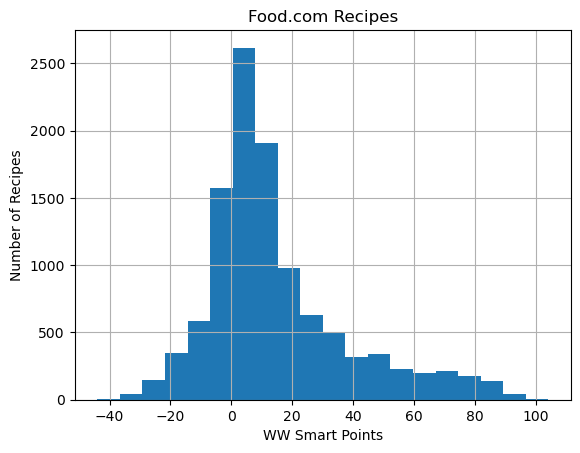

In [232]:
# Create a histogram of the points
clean_recipes['wws_points'].hist(bins=20)
plt.title("Food.com Recipes")
plt.xlabel("WW Smart Points")
plt.ylabel("Number of Recipes")
plt.show()

ShapiroResult(statistic=0.9041141271591187, pvalue=3.407905045251914e-17)

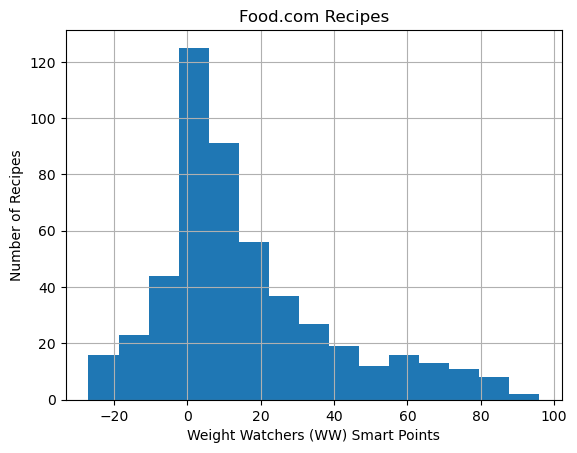

In [254]:
# Check for Gaussian distribution - using Shapiro-Wilk test
# Note: Shapiro-Wilk is sensitive to sample size
sample_set = clean_recipes['wws_points'].sample(n=500)
sample_set.hist(bins=15)
plt.title("Food.com Recipes")
plt.xlabel("Weight Watchers (WW) Smart Points")
plt.ylabel("Number of Recipes")

stats.shapiro(sample_set)
# A very high W-statistic suggests a good fit to a normal distribution.
# A near-zero p-value, for a Shapiro-Wilk test, rejects the null hypothesis, meaning NOT a normal distribution.

# Data Exploration - Spoonacular API

## API Test - Complex Search and Recipe Information
- Complex Search: [https://spoonacular.com/food-api/docs#Search-Recipes-Complex](https://spoonacular.com/food-api/docs#Search-Recipes-Complex)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- `Complex Search` returns the same result every time, need to try `Random Recipes`.

In [257]:
# API REQUEST - Complex Search.
def complex_search():
    recipe_url = "https://api.spoonacular.com/recipes/complexSearch"
    
    # Set request parameters
    recipe_params = {
        'apiKey': spoonacular_key,
        'number': 100}
    
    # Request a list of recipes.
    recipe_response = requests.get(recipe_url, recipe_params).json()
    
    # Output response to a csv
    recipes_df = pd.DataFrame(recipe_response['results'])
    recipes_df.to_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv', index=False)

# Uncomment the line below to run the API request
# complex_search()

In [259]:
# Import and display complex search results
recipes_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv')
print(f'recipes_df: {recipes_df.shape}')
recipes_df.head()

recipes_df: (100, 4)


,id,title,image,imageType
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,https://spoonacular.com/recipeImages/782585-31...,jpg
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",https://spoonacular.com/recipeImages/716426-31...,jpg
2,715497,Berry Banana Breakfast Smoothie,https://spoonacular.com/recipeImages/715497-31...,jpg
3,715415,Red Lentil Soup with Chicken and Turnips,https://spoonacular.com/recipeImages/715415-31...,jpg
4,716406,Asparagus and Pea Soup: Real Convenience Food,https://spoonacular.com/recipeImages/716406-31...,jpg


In [281]:
# API REQUEST - Recipe Information
def recipe_info(output_name):
    recipe_info = []
    for id in recipes_df['id']:
        info_url = f'https://api.spoonacular.com/recipes/{id}/information?'
        info_params = {
            'apiKey': spoonacular_key,
            'includeNutrition': "true"}
    
        info_response = requests.get(info_url, info_params).json()
        recipe_info.append(info_response)
    
    info_df = pd.DataFrame(recipe_info)
    info_df.to_csv(output_name, index=False)

# Uncomment the line below to run the API request
# recipe_info('Resources/02_raw_data/info_master_0.csv')

In [263]:
# While the API response is accessible, identify attributes of interest
def check_response():
    recipe_info[0].keys()
    
    # Generic metadata
    recipe_info[0]['id']
    recipe_info[0]['title']
    recipe_info[0]['aggregateLikes'] # will need to convert this to a 5-point scale
    recipe_info[0]['extendedIngredients'] # can use len() to get the number of ingredients
    recipe_info[0]['weightWatcherSmartPoints'] # research the equation for this
    recipe_info[0]['cuisines'] # identify recipes with non-empty results
    recipe_info[0]['dishTypes'] # will need to select a simpler subset
    
    # Nutritional values - amount, unit, percent of daily needs
    recipe_info[0]['nutrition']['nutrients'][0] # Calories
    recipe_info[0]['nutrition']['nutrients'][2] # Saturated Fat
    recipe_info[0]['nutrition']['nutrients'][5] # Sugar
    recipe_info[0]['nutrition']['nutrients'][7] # Sodium
    recipe_info[0]['nutrition']['nutrients'][8] # Protein

# Uncomment the line below to run the function after an API request
# check_response()

In [272]:
# Import and display recipe information results
info_df = pd.read_csv(f'Resources/02_raw_data/info_master_0.csv')

# Display the DataFrame and its columns
print(info_df.columns)
info_df.head()

Index(['vegetarian', 'vegan', 'glutenFree', 'dairyFree', 'veryHealthy',
       'cheap', 'veryPopular', 'sustainable', 'lowFodmap',
       'weightWatcherSmartPoints', 'gaps', 'preparationMinutes',
       'cookingMinutes', 'aggregateLikes', 'healthScore', 'creditsText',
       'sourceName', 'pricePerServing', 'extendedIngredients', 'id', 'title',
       'readyInMinutes', 'servings', 'sourceUrl', 'image', 'imageType',
       'nutrition', 'summary', 'cuisines', 'dishTypes', 'diets', 'occasions',
       'winePairing', 'instructions', 'analyzedInstructions', 'originalId',
       'spoonacularSourceUrl', 'license', 'author'],
      dtype='object')


,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,dishTypes,diets,occasions,winePairing,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,True,True,True,True,True,False,False,False,False,12,...,"['side dish', 'lunch', 'main course', 'salad',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['chardonnay', 'sauvignon blan...",Rinse the cannellini beans and soak for 8 hour...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cannellini-bean-and-as...,NaN,NaN
1,True,True,True,True,True,False,True,False,False,4,...,"['side dish', 'antipasti', 'starter', 'snack',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['wine', 'alcoholic drink', 'w...",<ol><li><span></span>Remove the cauliflower's ...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cauliflower-brown-rice...,CC BY-SA 3.0,NaN
2,True,False,False,False,True,False,True,False,False,15,...,"['morning meal', 'brunch', 'beverage', 'breakf...",['lacto ovo vegetarian'],[],"{'pairedWines': [], 'pairingText': '', 'produc...",<p>Take some yogurt in your favorite flavor an...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/berry-banana-breakfast...,NaN,NaN
3,False,False,True,True,True,False,True,False,False,11,...,"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free']","['fall', 'winter']","{'pairedWines': [], 'pairingText': '', 'produc...","To a large dutch oven or soup pot, heat the ol...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/red-lentil-soup-with-c...,NaN,NaN
4,True,True,True,True,True,False,False,False,False,2,...,"['antipasti', 'soup', 'starter', 'snack', 'app...","['gluten free', 'dairy free', 'paleolithic', '...","['fall', 'winter']","{'pairedWines': ['sparkling wine', 'sparkling ...",<ol><li><span></span>Chop the garlic and onion...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/asparagus-and-pea-soup...,CC BY-SA 3.0,NaN


In [278]:
# Parse the API response - all relevant columns, and account for different units
def parse_response(output_name):
    # Metadata
    recipe_id = []
    recipe_name = []
    recipe_likes = []
    meal_type = []
    cuisines = []
    num_ingredients = []
    ww_points = []
    
    # Calories
    calories_amt = []
    calories_unit = []
    calories_pct = []
    
    # Saturated Fat
    satfat_amt = []
    satfat_unit = []
    satfat_pct = []
    
    # Sugar
    sugar_amt = []
    sugar_unit = []
    sugar_pct = []
    
    # Sodium
    sodium_amt = []
    sodium_unit = []
    sodium_pct = []
    
    # Protein
    protein_amt = []
    protein_unit = []
    protein_pct = []
    
    for idx, row in enumerate(recipe_info):
        try:
            recipe_id.append(recipe_info[idx]['id'])
            recipe_name.append(recipe_info[idx]['title'])
            recipe_likes.append(recipe_info[idx]['aggregateLikes'])
            meal_type.append(recipe_info[idx]['dishTypes'])
            cuisines.append(recipe_info[idx]['cuisines'])
            num_ingredients.append(len(recipe_info[idx]['extendedIngredients']))
            ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])
            
            calories_amt.append(recipe_info[idx]['nutrition']['nutrients'][0]['amount'])
            calories_unit.append(recipe_info[idx]['nutrition']['nutrients'][0]['unit'])
            calories_pct.append(recipe_info[idx]['nutrition']['nutrients'][0]['percentOfDailyNeeds'])
            
            satfat_amt.append(recipe_info[idx]['nutrition']['nutrients'][2]['amount'])
            satfat_unit.append(recipe_info[idx]['nutrition']['nutrients'][2]['unit'])
            satfat_pct.append(recipe_info[idx]['nutrition']['nutrients'][2]['percentOfDailyNeeds'])
            
            sugar_amt.append(recipe_info[idx]['nutrition']['nutrients'][5]['amount'])
            sugar_unit.append(recipe_info[idx]['nutrition']['nutrients'][5]['unit'])
            sugar_pct.append(recipe_info[idx]['nutrition']['nutrients'][5]['percentOfDailyNeeds'])
            
            sodium_amt.append(recipe_info[idx]['nutrition']['nutrients'][7]['amount'])
            sodium_unit.append(recipe_info[idx]['nutrition']['nutrients'][7]['unit'])
            sodium_pct.append(recipe_info[idx]['nutrition']['nutrients'][7]['percentOfDailyNeeds'])
            
            protein_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
            protein_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
            protein_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])
        
        except:
            print(idx)
    
    spoonacular_df = pd.DataFrame({
        'ID': recipe_id,
        'Name': recipe_name,
        'Likes': recipe_likes,
        'Meal Type': meal_type,
        'Cuisines': cuisines,
        'N_ingredients': num_ingredients,
        'WW Smart Points': ww_points,
        'Calories (Amount)': calories_amt,
        'Calories (Unit)': calories_unit,
        'Calories (% of Daily Needs)': calories_pct,
        'Saturated Fat (Amount)': satfat_amt,
        'Saturated Fat (Unit)': satfat_unit,
        'Saturated Fat (% of Daily Needs)': satfat_pct,
        'Sugar (Amount)': sugar_amt,
        'Sugar (Unit)': sugar_unit,
        'Sugar (% of Daily Needs)': sugar_pct,
        'Sodium (Amount)': sodium_amt,
        'Sodium (Unit)': sodium_unit,
        'Sodium (% of Daily Needs)': sodium_pct,
        'Protein (Amount)': protein_amt,
        'Protein (Unit)': protein_unit,
        'Protein (% of Daily Needs)': protein_pct})
    
    spoonacular_df.to_csv(output_name, index=False)

# Uncomment the line below to run the function after an API request
# parse_complex('Resources/03_simplified_data/initial_nutrition_0.csv')

In [274]:
# Import and display recipe information results
simple_df = pd.read_csv(f'Resources/03_simplified_data/initial_nutrition_0.csv')

# Display the DataFrame and its columns
print(simple_df.columns)
simple_df.head()

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)'],
      dtype='object')


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",3689,"['side dish', 'antipasti', 'starter', 'snack',...","['Chinese', 'Asian']",15,4,220.82,kcal,11.04,...,6.99,5.29,g,5.87,445.90,mg,19.39,9.03,g,18.05
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
4,716406,Asparagus and Pea Soup: Real Convenience Food,207,"['antipasti', 'soup', 'starter', 'snack', 'app...",[],8,2,452.33,kcal,22.62,...,8.34,27.99,g,31.10,25.76,mg,1.12,26.56,g,53.12


In [276]:
# Check the units columns
units_columns = ['Calories (Unit)', 'Saturated Fat (Unit)', 'Sugar (Unit)', 'Sodium (Unit)', 'Protein (Unit)']
for col in units_columns:
    check = simple_df['Protein (Unit)'].unique()
    print(f"Unit check: {col} {check}")

Unit check: Calories (Unit) ['g' 'mg']
Unit check: Saturated Fat (Unit) ['g' 'mg']
Unit check: Sugar (Unit) ['g' 'mg']
Unit check: Sodium (Unit) ['g' 'mg']
Unit check: Protein (Unit) ['g' 'mg']


## API Test - Random Recipes and Recipe Information
- Random Recipes: [https://spoonacular.com/food-api/docs#Get-Random-Recipes](https://spoonacular.com/food-api/docs#Get-Random-Recipes)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- Once converted to a dataframe, the data is not as accessible as navigating the API response, will need to create a simplified dataframe while the API response is available.
- Although this has metadata, it still does not have `Nutrition` information, will still need to run the `Recipe Information` request. Need to identify a cost-effective API request methodology.

In [280]:
# API REQUEST - Random Recipe
def random_recipe(output_name):
    random_url = "https://api.spoonacular.com/recipes/random?"
    
    # Set request parameters
    random_params = {
        'apiKey': spoonacular_key,
        'number': 100}
    
    # Request a list of random recipe IDs.
    random_response = requests.get(random_url, random_params).json()
    
    # Output response to a csv
    random_df = pd.DataFrame(random_response['recipes'])
    random_df.to_csv(output_name, index=False)

# Uncomment the line below to run the API request
# random_recipe('Resources/01_recipe_IDs/initial_recipes_4.csv')

In [268]:
# Import and display random recipes results
random_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_4.csv')
random_df.head()

,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,cuisines,dishTypes,diets,occasions,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,False,False,False,False,False,False,False,False,False,28,...,['American'],"['lunch', 'main course', 'main dish', 'dinner']",[],[],<ol><li>Preheat broiler. </li><li>Heat large f...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tex-mex-burger-663050,NaN,NaN
1,False,False,False,False,False,False,False,False,False,39,...,[],['dessert'],[],[],<ol><li>Preheat oven to 180 degrees C</li><li>...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/chocolate-banoffee-pie...,CC BY 3.0,NaN
2,True,True,True,True,False,False,False,False,False,3,...,[],"['side dish', 'antipasti', 'salad', 'starter',...","['gluten free', 'dairy free', 'paleolithic', '...",['christmas'],Finely grate enough zest from the orange to me...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/fennel-and-orange-sala...,CC BY 3.0,NaN
3,False,False,False,True,False,False,False,False,False,12,...,['Mexican'],"['lunch', 'main course', 'main dish', 'dinner']","['dairy free', 'pescatarian']",[],In pie pan/deep dish add your Italian bread cr...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/kks-fish-tacos-648974,NaN,NaN
4,True,True,True,True,True,False,False,False,False,6,...,[],"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free', 'lacto ovo veget...","['fall', 'winter']",<ol><li>Rinse the beans thoroughly and place t...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tuscan-white-bean-soup...,NaN,NaN


In [282]:
# API REQUEST - Recipe Information and parse response

# Uncomment the line below to run the API request
# recipe_info('Resources/02_raw_data/info_master_4.csv')

# Uncomment the line below to parse the API request response
# parse_response('Resources/03_simplified_data/initial_nutrition_4.csv')

## API Test - Random Recipes and Nutrition by ID

In [283]:
# API REQUEST - Random Recipe and Nutrition by ID

# Uncomment the line below to run the API request
# recipe_info('Resources/02_raw_data/info_master_5.csv')

def nutrition_id(output_name):
    nutrition_info = []
    for id in random_df['id']:
        nutrition_url = f"https://api.spoonacular.com/recipes/{id}/nutritionWidget.json"
        nutrition_params = {'apiKey': spoonacular_key}

        # Request recipe information for each recipe ID
        nutrition_response = requests.get(nutrition_url, nutrition_params).json()
        nutrition_info.append(nutrition_response)

    # Output response to a csv
    nutrition_df = pd.DataFrame(nutrition_info)
    nutrition_df.to_csv()

# Uncomment the line below to run the API request
# nutrition_id('Resources/02_raw_data/info_master_5.csv')

In [284]:
# Parse the response - added carbohydrates
def parse_metadata(input_csv, output_name):
    # Metadata
    metadata = pd.read_csv(input_csv)
    num_ingredients = []
    carbs = []

    # Calories
    calories_amt = []
    calories_unit = []
    calories_pct = []
    
    # Saturated Fat
    satfat_amt = []
    satfat_unit = []
    satfat_pct = []
    
    # Sugar
    sugar_amt = []
    sugar_unit = []
    sugar_pct = []
    
    # Sodium
    sodium_amt = []
    sodium_unit = []
    sodium_pct = []
    
    # Protein
    protein_amt = []
    protein_unit = []
    protein_pct = []
    
    for idx, row in enumerate(nutrition_info):
        try:
            num_ingredients.append(len(nutrition_info[idx]['ingredients']))
            carbs.append(nutrition_info[idx]['carbs'])
            calories_amt.append(nutrition_info[idx]['nutrients'][0]['amount'])
            calories_unit.append(nutrition_info[idx]['nutrients'][0]['unit'])
            calories_pct.append(nutrition_info[idx]['nutrients'][0]['percentOfDailyNeeds'])
            
            satfat_amt.append(nutrition_info[idx]['nutrients'][2]['amount'])
            satfat_unit.append(nutrition_info[idx]['nutrients'][2]['unit'])
            satfat_pct.append(nutrition_info[idx]['nutrients'][2]['percentOfDailyNeeds'])
            
            sugar_amt.append(nutrition_info[idx]['nutrients'][5]['amount'])
            sugar_unit.append(nutrition_info[idx]['nutrients'][5]['unit'])
            sugar_pct.append(nutrition_info[idx]['nutrients'][5]['percentOfDailyNeeds'])
            
            sodium_amt.append(nutrition_info[idx]['nutrients'][7]['amount'])
            sodium_unit.append(nutrition_info[idx]['nutrients'][7]['unit'])
            sodium_pct.append(nutrition_info[idx]['nutrients'][7]['percentOfDailyNeeds'])
            
            protein_amt.append(nutrition_info[idx]['nutrients'][8]['amount'])
            protein_unit.append(nutrition_info[idx]['nutrients'][8]['unit'])
            protein_pct.append(nutrition_info[idx]['nutrients'][8]['percentOfDailyNeeds'])
        
        except:
            print(idx)
    
    spoonacular_df = pd.DataFrame({
        'ID': metadata['id'],
        'Name': metadata['title'],
        'Likes': metadata['aggregateLikes'],
        'Meal Type': metadata['dishTypes'],
        'Cuisines': metadata['cuisines'],
        'N_ingredients': num_ingredients,
        'WW Smart Points': metadata['weightWatcherSmartPoints'],
        'Calories (Amount)': calories_amt,
        'Calories (Unit)': calories_unit,
        'Calories (% of Daily Needs)': calories_pct,
        'Saturated Fat (Amount)': satfat_amt,
        'Saturated Fat (Unit)': satfat_unit,
        'Saturated Fat (% of Daily Needs)': satfat_pct,
        'Sugar (Amount)': sugar_amt,
        'Sugar (Unit)': sugar_unit,
        'Sugar (% of Daily Needs)': sugar_pct,
        'Sodium (Amount)': sodium_amt,
        'Sodium (Unit)': sodium_unit,
        'Sodium (% of Daily Needs)': sodium_pct,
        'Protein (Amount)': protein_amt,
        'Protein (Unit)': protein_unit,
        'Protein (% of Daily Needs)': protein_pct,
        'Carbohydrates': carbs})
    
    spoonacular_df.to_csv(output_name, index=False)

# Uncomment the lines below to run the function after an API request
# parse_metadata(
#     'Resources/01_recipe_IDs/initial_recipes_5.csv',
#     'Resources/03_simplified_data/initial_nutrition_5.csv')

## Spoonacular API Data Collection - Method 1
- API request cost comparison:
    1. `Random Recipes` + `Recipe Information` = 2.1 points per request
    2. `Random Recipes` + `Nutrition` = 2 points per request

In [319]:
def spoonacular_v1():
    ### PHASE 1 - Get Recipe IDs ###
    # API REQUEST - Random Recipe
    random_url = "https://api.spoonacular.com/recipes/random?"

    # Set request parameters
    random_params = {
        'apiKey': spoonacular_key,
        'number': 100}
    
    # Request a list of random recipe IDs.
    random_response = requests.get(random_url, random_params).json()
    
    # Output response to a csv
    random_df = pd.DataFrame(random_response['recipes'])
    random_df.to_csv(f'Resources/01_recipe_IDs/initial_recipes_{recipe_folder()}.csv', index=False)

    ### PHASE 2 - Get Nutrition by ID ###
    # API REQUEST - Nutrition by ID
    nutrition_info = []
    for id in random_df['id']:
        nutrition_url = f'https://api.spoonacular.com/recipes/{id}/nutritionWidget.json'
        nutrition_params = {'apiKey': spoonacular_key}

        # Request recipe information for each recipe ID
        nutrition_response = requests.get(nutrition_url, nutrition_params).json()
        nutrition_info.append(nutrition_response)

    # Output response to a csv
    nutrition_df = pd.DataFrame(nutrition_info)
    nutrition_df.to_csv(f'Resources/02_raw_data/info_master_{raw_folder()}.csv')

    ### PHASE 3 - Parse response ###
    # Metadata
    metadata = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_{recipe_folder()-1}.csv')
    num_ingredients = []
    carbs = []

    # Calories
    calories_amt = []
    calories_unit = []
    calories_pct = []
    
    # Saturated Fat
    satfat_amt = []
    satfat_unit = []
    satfat_pct = []
    
    # Sugar
    sugar_amt = []
    sugar_unit = []
    sugar_pct = []
    
    # Sodium
    sodium_amt = []
    sodium_unit = []
    sodium_pct = []
    
    # Protein
    protein_amt = []
    protein_unit = []
    protein_pct = []
    
    for idx, row in enumerate(nutrition_info):
        try:
            num_ingredients.append(len(nutrition_info[idx]['ingredients']))
            carbs.append(nutrition_info[idx]['carbs'])
            calories_amt.append(nutrition_info[idx]['nutrients'][0]['amount'])
            calories_unit.append(nutrition_info[idx]['nutrients'][0]['unit'])
            calories_pct.append(nutrition_info[idx]['nutrients'][0]['percentOfDailyNeeds'])
            
            satfat_amt.append(nutrition_info[idx]['nutrients'][2]['amount'])
            satfat_unit.append(nutrition_info[idx]['nutrients'][2]['unit'])
            satfat_pct.append(nutrition_info[idx]['nutrients'][2]['percentOfDailyNeeds'])
            
            sugar_amt.append(nutrition_info[idx]['nutrients'][5]['amount'])
            sugar_unit.append(nutrition_info[idx]['nutrients'][5]['unit'])
            sugar_pct.append(nutrition_info[idx]['nutrients'][5]['percentOfDailyNeeds'])
            
            sodium_amt.append(nutrition_info[idx]['nutrients'][7]['amount'])
            sodium_unit.append(nutrition_info[idx]['nutrients'][7]['unit'])
            sodium_pct.append(nutrition_info[idx]['nutrients'][7]['percentOfDailyNeeds'])
            
            protein_amt.append(nutrition_info[idx]['nutrients'][8]['amount'])
            protein_unit.append(nutrition_info[idx]['nutrients'][8]['unit'])
            protein_pct.append(nutrition_info[idx]['nutrients'][8]['percentOfDailyNeeds'])
        
        except:
            print(idx)
    
    spoonacular_df = pd.DataFrame({
        'ID': metadata['id'],
        'Name': metadata['title'],
        'Likes': metadata['aggregateLikes'],
        'Meal Type': metadata['dishTypes'],
        'Cuisines': metadata['cuisines'],
        'N_ingredients': num_ingredients,
        'WW Smart Points': metadata['weightWatcherSmartPoints'],
        'Calories (Amount)': calories_amt,
        'Calories (Unit)': calories_unit,
        'Calories (% of Daily Needs)': calories_pct,
        'Saturated Fat (Amount)': satfat_amt,
        'Saturated Fat (Unit)': satfat_unit,
        'Saturated Fat (% of Daily Needs)': satfat_pct,
        'Sugar (Amount)': sugar_amt,
        'Sugar (Unit)': sugar_unit,
        'Sugar (% of Daily Needs)': sugar_pct,
        'Sodium (Amount)': sodium_amt,
        'Sodium (Unit)': sodium_unit,
        'Sodium (% of Daily Needs)': sodium_pct,
        'Protein (Amount)': protein_amt,
        'Protein (Unit)': protein_unit,
        'Protein (% of Daily Needs)': protein_pct,
        'Carbohydrates': carbs})
    
    spoonacular_df.to_csv(f'Resources/03_simplified_data/initial_nutrition_{simple_folder()}.csv', index=False)

# Uncomment the line below to run the API request
# spoonacular_v1()

## Spoonacular API Data Collection - Method 2

In [320]:
def spoonacular_v2():
    ### PHASE 1 - Get Recipes with all information required ###
    # API REQUEST - Complex Search.
    recipe_url = "https://api.spoonacular.com/recipes/complexSearch"
    
    # Set request parameters
    recipe_params = {
        'apiKey': spoonacular_key,
        'number': 100,
        'cuisine': cuisine_match,
        'type': "breakfast", # Run again with "lunch" and "dinner"
        'addRecipeNutrition': True}
    
    # Request a list of recipes.
    recipe_response = requests.get(recipe_url, recipe_params).json()
    
    # Output response to a csv
    recipes_df = pd.DataFrame(recipe_response['results'])
    file_index = complex_folder()
    recipes_df.to_csv(f'Resources/04_complex_test/recipe_data_{file_index}.csv', index=False)

    ### PHASE 2 - Parse response ###
    # Metadata
    recipe_id = []
    recipe_name = []
    recipe_likes = []
    meal_type = []
    cuisines = []
    num_ingredients = []
    ww_points = []
    mins_cook = []
    mins_prep = []
    
    # Calories
    calories_amt = []
    calories_unit = []
    calories_pct = []
    
    # Saturated Fat
    satfat_amt = []
    satfat_unit = []
    satfat_pct = []
    
    # Sugar
    sugar_amt = []
    sugar_unit = []
    sugar_pct = []
    
    # Sodium
    sodium_amt = []
    sodium_unit = []
    sodium_pct = []
    
    # Protein
    protein_amt = []
    protein_unit = []
    protein_pct = []
    
    # Carbohydrates
    carbs_amt = []
    carbs_unit = []
    carbs_pct = []
    
    recipe_info = recipe_response['results']
    for idx, row in enumerate(recipe_info):
        recipe_id.append(recipe_info[idx]['id'])
        recipe_name.append(recipe_info[idx]['title'])
        recipe_likes.append(recipe_info[idx]['aggregateLikes'])
        meal_type.append(recipe_info[idx]['dishTypes'])
        cuisines.append(recipe_info[idx]['cuisines'])
        num_ingredients.append(len(recipe_info[idx]['nutrition']['ingredients']))
        ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])
        mins_cook.append(recipe_info[idx]['cookingMinutes'])
        mins_prep.append(recipe_info[idx]['preparationMinutes'])
        
        calories_amt.append(recipe_info[idx]['nutrition']['nutrients'][0]['amount'])
        calories_unit.append(recipe_info[idx]['nutrition']['nutrients'][0]['unit'])
        calories_pct.append(recipe_info[idx]['nutrition']['nutrients'][0]['percentOfDailyNeeds'])
        
        satfat_amt.append(recipe_info[idx]['nutrition']['nutrients'][2]['amount'])
        satfat_unit.append(recipe_info[idx]['nutrition']['nutrients'][2]['unit'])
        satfat_pct.append(recipe_info[idx]['nutrition']['nutrients'][2]['percentOfDailyNeeds'])
        
        sugar_amt.append(recipe_info[idx]['nutrition']['nutrients'][5]['amount'])
        sugar_unit.append(recipe_info[idx]['nutrition']['nutrients'][5]['unit'])
        sugar_pct.append(recipe_info[idx]['nutrition']['nutrients'][5]['percentOfDailyNeeds'])
        
        sodium_amt.append(recipe_info[idx]['nutrition']['nutrients'][7]['amount'])
        sodium_unit.append(recipe_info[idx]['nutrition']['nutrients'][7]['unit'])
        sodium_pct.append(recipe_info[idx]['nutrition']['nutrients'][7]['percentOfDailyNeeds'])
        
        protein_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
        protein_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
        protein_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])
    
        carbs_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
        carbs_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
        carbs_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])
    
    spoonacular_df = pd.DataFrame({
        'ID': recipe_id,
        'Name': recipe_name,
        'Likes': recipe_likes,
        'Meal Type': meal_type,
        'Cuisines': cuisines,
        'N_ingredients': num_ingredients,
        'WW Smart Points': ww_points,
        'Cooking Minutes': mins_cook,
        'Prep Minutes': mins_prep,
        'Calories (Amount)': calories_amt,
        'Calories (Unit)': calories_unit,
        'Calories (% of Daily Needs)': calories_pct,
        'Saturated Fat (Amount)': satfat_amt,
        'Saturated Fat (Unit)': satfat_unit,
        'Saturated Fat (% of Daily Needs)': satfat_pct,
        'Sugar (Amount)': sugar_amt,
        'Sugar (Unit)': sugar_unit,
        'Sugar (% of Daily Needs)': sugar_pct,
        'Sodium (Amount)': sodium_amt,
        'Sodium (Unit)': sodium_unit,
        'Sodium (% of Daily Needs)': sodium_pct,
        'Protein (Amount)': protein_amt,
        'Protein (Unit)': protein_unit,
        'Protein (% of Daily Needs)': protein_pct,
        'Carbs (Amount)': carbs_amt,
        'Carbs (Unit)': carbs_unit,
        'Carbs (% of Daily Needs)': carbs_pct})
    
    spoonacular_df.to_csv(f'Resources/04_complex_test/simplified_data_{file_index}.csv', index=False)

# Uncomment the line below to run the API request
# spoonacular_v2()

## Get Recipe IDs from Raw Data

In [367]:
# Get list of subdirectories in the Resources folder
from pathlib import Path
subdir_list = []
for path in Path('Resources').iterdir():
    if (path == Path('Resources/.ipynb_checkpoints')):
        continue
    elif path.is_dir():
        subdir_list.append(path)

# Loop over folders without simplified data
raw_ids = []
for dir in subdir_list[0:2]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints'):
            csv_df = pd.read_csv(f'{dir}/{file.name}')
            try:
                raw_ids.append(csv_df['id'])
            except:
                # If no 'id' column, move on to the next csv
                continue

# Flatten raw_ids
raw_list = [id for row in raw_ids for id in row]

# Get a unique list of recipe IDs
unique_raw = list(set(raw_list))
print(f'Unique out of raw data: {len(unique_raw)} of {len(raw_list)}')

# Loop over folders with simplified data
simple_ids = []
for dir in subdir_list[2:]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints') & (file.name.split('.')[-1] == 'csv'):
                csv_df = pd.read_csv(f'{dir}/{file.name}')
                try:
                    simple_ids.append(csv_df['id'])
                except:
                    # If no 'id' column, move on to the next csv
                    continue

# Flatten simple_ids
simple_list = [id for row in simple_ids for id in row]
unique_simple = list(set(simple_list))
print(f'Unique out of simplified data: {len(unique_simple)} of {len(simple_list)}')

# Identify the intersection between the unique raw and unique simplified data - STRUGGLING TO UNDERSTAND WHAT THIS MEANS, get the dfs!
intersect_ids = []
if set(unique_raw) & set(unique_simple):
    intersect_ids.append(set(unique_raw) & set(unique_simple))
print(f'Total intersection: {len(intersect_ids[0])}')

Unique out of raw data: 974 of 1400
Unique out of simplified data: 349 of 388
Total intersection: 115


# CUTOFF

In [212]:
import numpy as np
points_bins = np.arange(-50, 105, 10)
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
WWS Point Ranges,,,,,,,,,,,,,,,,,,,,
"(-50, -40]",180747.000000,25.000000,2.396957e+05,5.666667,7.000000,4.904762,346.400000,11.333333,6.666667,14.333333,117.333333,11.666667,1.666667,7.366667,3.333333,0.344000,58.666667,2.333333,5.000000,-42.333333
"(-40, -30]",215694.847826,41.608696,2.456677e+05,9.673913,8.347826,4.548778,418.921739,29.282609,4.239130,22.500000,102.717391,30.804348,1.630435,19.033696,2.119565,0.540000,51.358696,6.160870,4.891304,-33.347826
"(-30, -20]",195989.077586,44.284483,2.432182e+05,10.237069,9.172414,4.576518,426.462931,33.012931,6.025862,22.262931,85.478448,36.754310,3.383621,21.458405,3.012931,0.534310,42.739224,7.350862,10.150862,-23.245690
"(-20, -10]",190860.945568,39.786936,3.344094e+06,9.900467,9.349922,4.573846,388.672473,30.984448,8.222395,24.608087,66.564541,35.780715,4.867807,20.139891,4.111198,0.590594,33.282271,7.156143,14.603421,-13.864697
"(-10, 0]",207686.643905,37.143905,5.473336e+06,9.823928,9.160835,4.595998,328.908804,26.841986,9.408578,23.781603,42.611738,34.323363,6.245485,17.447291,4.704289,0.570758,21.305869,6.864673,18.736456,-3.317156
"(0, 10]",213097.328708,35.245447,1.320186e+06,9.477016,8.760335,4.581924,256.107806,20.493206,10.812374,17.847355,21.645562,26.237063,6.977161,13.320584,5.406187,0.428337,10.822781,5.247413,20.931483,5.144840
"(10, 20]",213162.528634,36.880507,4.333912e+06,9.328194,9.409141,4.626892,304.578744,25.043502,23.882709,19.672907,21.089207,29.861784,9.021476,16.278276,11.941355,0.472150,10.544604,5.972357,27.064427,14.933921
"(20, 30]",217549.556634,36.965480,2.199455e+06,9.211435,9.352751,4.609210,296.684790,22.747573,39.450917,17.783172,18.650485,26.692557,9.784250,14.785922,19.725458,0.426796,9.325243,5.338511,29.352751,25.032362
"(30, 40]",220884.751332,35.218472,2.807851e+05,9.488455,8.898757,4.624889,289.057016,20.978686,54.820604,13.877442,16.511545,25.216696,10.255773,13.636146,27.410302,0.333059,8.255773,5.043339,30.767318,35.008881


The r-value is: 0.03836642325308373


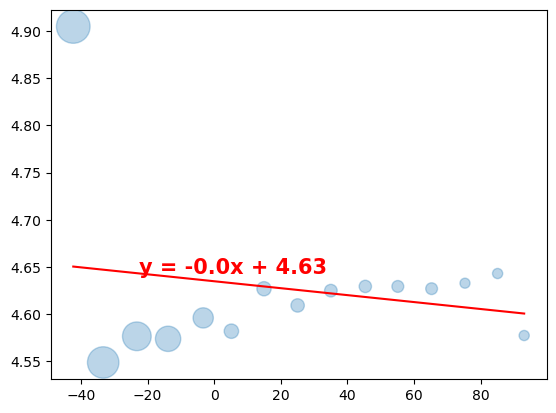

In [214]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

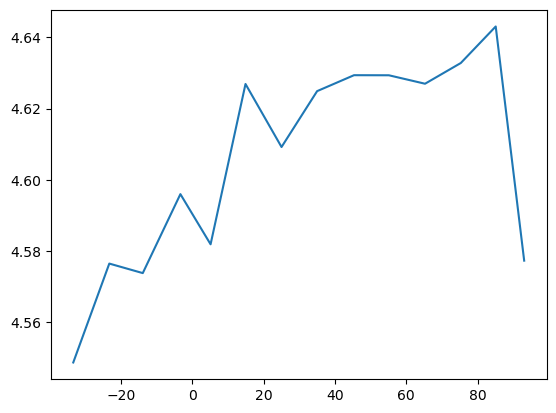

In [177]:
plt.plot(x_val, y_val)

In [146]:
binned_df['wws_points'].describe()

count    15.000000
mean     25.543119
std      43.817544
min     -42.333333
25%      -8.590926
50%      25.032362
75%      60.188320
max      93.051282
Name: wws_points, dtype: float64

In [185]:
# Check recipes <40 wws_points
low_points = clean_recipes.loc[clean_recipes['wws_points'] < -40]
low_points

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
9042,asian flavoured chicken burgers oamc,290232,15,506519,2008-03-05,"['lactose', '15-minutes-or-less', 'time-to-mak...","[375.6, 14.0, 5.0, 12.0, 114.0, 12.0, 3.0]",4,['place all ingredients in a bowl and mix unti...,light and freshly flavoured burgers. these are...,...,114.0,12.0,3.0,9.10,2.5,0.288,57.0,2.4,9.0,-41
78163,egyptian red snapper in red pepper mint sauce,133946,20,183964,2005-08-18,"['30-minutes-or-less', 'time-to-make', 'course...","[328.6, 9.0, 7.0, 5.0, 120.0, 5.0, 1.0]",4,"['saute onion in olive oil until golden', 'add...",this recipe is posted for the zaar world tour ...,...,120.0,5.0,1.0,5.85,3.5,0.120,60.0,1.0,3.0,-44
183106,simple salsa chicken,118063,40,28604,2005-04-19,"['60-minutes-or-less', 'time-to-make', 'course...","[335.0, 11.0, 8.0, 26.0, 118.0, 18.0, 1.0]",9,['spray a shallow baking dish with cooking spr...,"ok, so this can serve 10 people, if each perso...",...,118.0,18.0,1.0,7.15,4.0,0.624,59.0,3.6,3.0,-42


15
The r-value is: 0.5412112542721187


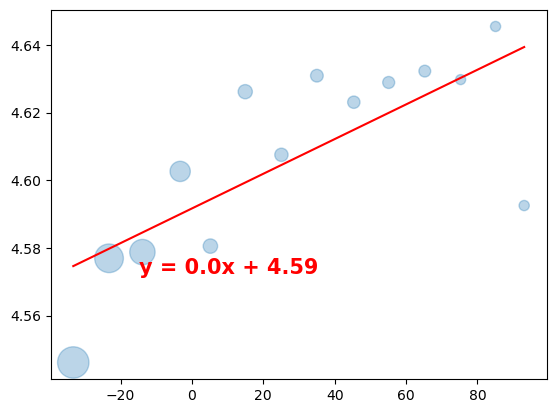

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
count,328.000000,328.000000,3.280000e+02,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,262108.841463,47.003049,4.047309e+05,11.634146,9.850610,4.574119,287.076220,21.658537,28.542683,17.652439,25.585366,28.091463,8.478659,14.078049,14.271341,0.423659,12.792683,5.618293,25.435976,14.899390
std,149075.311924,29.127002,4.831138e+05,6.010210,3.895296,0.643205,175.020052,17.951324,30.259803,15.523522,23.911509,26.924248,6.103052,11.668360,15.129901,0.372565,11.955755,5.384850,18.309157,21.922694
min,10781.000000,2.000000,1.533000e+03,2.000000,2.000000,1.000000,5.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.000000
25%,144800.000000,25.000000,6.466700e+04,7.000000,7.000000,4.350000,160.800000,8.000000,7.000000,6.000000,8.000000,7.000000,4.000000,5.200000,3.500000,0.144000,4.000000,1.400000,12.000000,1.000000
50%,259724.500000,40.000000,2.420545e+05,11.000000,9.000000,4.857143,251.850000,18.000000,16.000000,13.000000,18.000000,21.000000,8.000000,11.700000,8.000000,0.312000,9.000000,4.200000,24.000000,8.000000
75%,390983.250000,61.250000,4.887718e+05,15.000000,12.000000,5.000000,379.625000,31.000000,40.000000,25.250000,38.000000,41.250000,12.000000,20.150000,20.000000,0.606000,19.000000,8.250000,36.000000,23.000000
max,514340.000000,128.000000,2.324285e+06,41.000000,23.000000,5.000000,1006.100000,80.000000,137.000000,69.000000,115.000000,129.000000,34.000000,52.000000,68.500000,1.656000,57.500000,25.800000,102.000000,91.000000


In [237]:
no_oamc = parse_tags(['oamc-freezer-make-ahead'], clean_recipes, 'id')
test_df = clean_recipes.loc[~clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test_df

points_bins = np.arange(-40, 105, 10)
print(len(points_bins))
bins_df = pd.cut(test_df['wws_points'], bins=points_bins)
points_df = test_df.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

test1_df = clean_recipes.loc[clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test1_df.describe()

ShapiroResult(statistic=0.8912755250930786, pvalue=2.5248354369443428e-18)

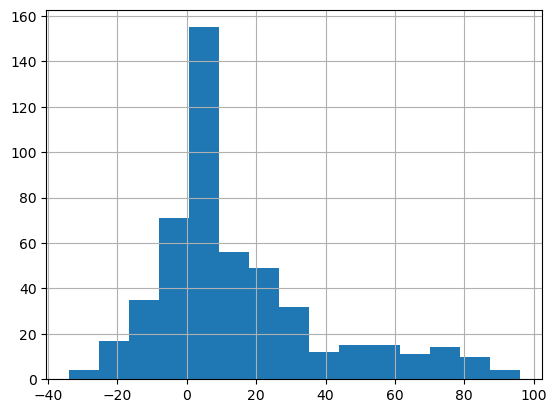

In [246]:
# STATISTICAL TESTING and PLOTS
sample_set = clean_recipes['wws_points'].sample(n=500)
sample_set.hist(bins=15)

stats.shapiro(sample_set)

In [236]:
result = stats.anderson(clean_recipes['wws_points'])

print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 404.916
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [54]:
# Parse the ingredients column
# Identify how to isolate each tag
tag_string = clean_recipes['ingredients'][1].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_ingredients = []
for string in clean_recipes['ingredients']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_ingredients:
            unique_ingredients.append(tag)

# Display the tags alphabetically
print(f"Number of unique ingredients: {len(unique_ingredients)}")

sorted_ingredients = sorted(unique_ingredients)
sorted_ingredients

for row in range(0, 52):
    sorted_ingredients[row] = sorted_ingredients[row].strip('"')
sorted_ingredients

# open file
with open('ingredients_commas.txt', 'w+') as f:
     
    # write elements of list
    for items in sorted_ingredients:
        f.write('%s, ' %items)
    print("File written successfully")
 
 
# close the file
f.close()
# # for line in sorted_ingredients[0:52]:
# #     print(line.strip('"'))
# sorted = [line.strip('"') for line in unique_ingredients[0:52]]
# unique_ingredients[0:52]

Number of unique ingredients: 5659
File written successfully


In [60]:
import food
report = food.get_report()
report[32]['Description']

'Soy milk'

In [78]:
categories = []
for row in range(len(report)):
    categories.append(report[row]['Category'])

new_data = set(categories)
old_data = set(sorted_ingredients)

# if (new_data & old_data):
#     print(new_data & old_data)
if len(new_data.intersection(old_data)) > 0:
    print(new_data.intersection(old_data))
else:
    print("no common elements")
new_data = set([word.lower() for word in list(new_data)])
old_data = set([word.lower() for word in list(old_data)])

if len(new_data.intersection(old_data)) > 0:
    intersect = new_data.intersection(old_data)
    print(len(intersect))
    print(intersect)
else:
    print("no common elements")

# Return dataframe with these common ingredients


no common elements
452
{'oyster sauce', 'icing', 'cocoa powder', 'honey', 'mayonnaise', 'croutons', 'jicama', 'eel', 'sauerkraut', 'pear', 'teriyaki sauce', 'corn', 'cream', 'whiskey', 'truffles', 'peas and carrots', 'chocolate milk', 'greens', 'olives', 'eggnog', 'fish', 'tartar sauce', 'soybeans', 'scotch', 'lychee', 'apples', 'grapes', 'plums', 'cherry pie filling', 'tuna', 'pancake syrup', 'apricots', 'vegetarian chili', 'carrots', 'meatballs', 'pistachio nuts', 'garlic', 'pastrami', 'mexican chocolate', 'jelly', 'guava', 'walnut oil', 'strawberries', 'lobster', 'vodka', 'seafood sauce', 'coconut milk', 'peaches', 'raspberries', 'macadamia nuts', 'worcestershire sauce', 'almonds', 'buckwheat groats', 'guava paste', 'shortening', 'meringues', 'tuna salad', 'grapefruit juice', 'pears', 'plantain chips', 'salad dressing', 'hot pepper sauce', 'chocolate', 'yellow rice', 'safflower oil', 'hazelnuts', 'refried beans', 'minestrone soup', 'grape juice', 'mixed vegetables', 'red pepper', 's

In [198]:
# Recipes with negative points are high in protein
negative_points = clean_recipes.loc[clean_recipes['wws_points'] < 0].copy()
print(f'negative_points: {negative_points.shape}')
negative_points.head()

negative_points: (2348, 27)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,22.0,35.0,1.0,11.70,0.0,0.408,11.0,7.0,3.0,-4
96,the woiks dilly burgers,34930,32,23302,2002-07-24,"['bacon', '60-minutes-or-less', 'time-to-make'...","[449.2, 50.0, 16.0, 19.0, 58.0, 67.0, 2.0]",8,"['in a bowl , mix together the ground beef , m...",NaN,...,58.0,67.0,2.0,32.50,8.0,0.456,29.0,13.4,6.0,-1
207,jamaican me hungry chicken bake,161370,65,59780,2006-03-24,"['time-to-make', 'course', 'main-ingredient', ...","[226.6, 15.0, 15.0, 6.0, 51.0, 8.0, 2.0]",10,"['for the rub , combine all ingredients in a z...",as this bakes your house will be filled with t...,...,51.0,8.0,2.0,9.75,7.5,0.144,25.5,1.6,6.0,-9
323,biggest loser fish tacos,392158,50,280271,2009-09-28,"['60-minutes-or-less', 'time-to-make', 'course...","[323.5, 13.0, 9.0, 32.0, 40.0, 12.0, 13.0]",12,['to make the fish: place the fish in a shallo...,"this is out of the ""biggest loser"" cookbook \r...",...,40.0,12.0,13.0,8.45,4.5,0.768,20.0,2.4,39.0,-4
460,no more fears paella,439143,70,349619,2010-10-11,"['time-to-make', 'course', 'main-ingredient', ...","[462.6, 26.0, 13.0, 42.0, 56.0, 22.0, 14.0]",20,"['1', 'season shrimps , cover with plastic wra...","certainly not the authentic paella, but my ver...",...,56.0,22.0,14.0,16.90,6.5,1.008,28.0,4.4,42.0,-4


The r-value is: 0.4066116978373996


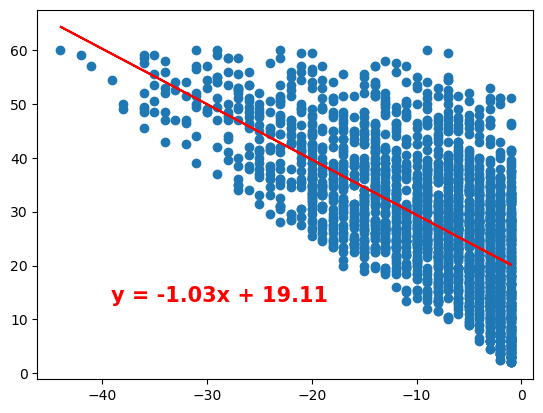

In [199]:
x_values = negative_points['wws_points']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

The r-value is: 0.3392225034551668


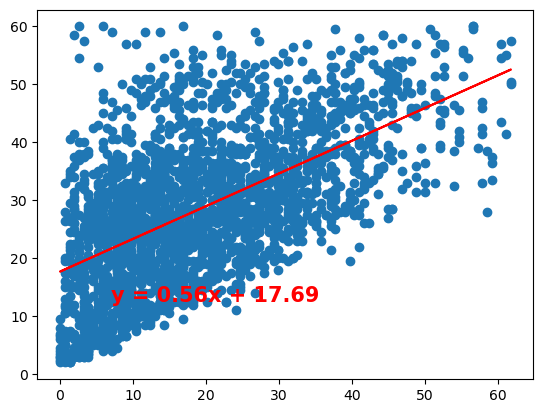

In [200]:
x_values = negative_points['total_fat_g']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

The r-value is: 0.6167998733292949


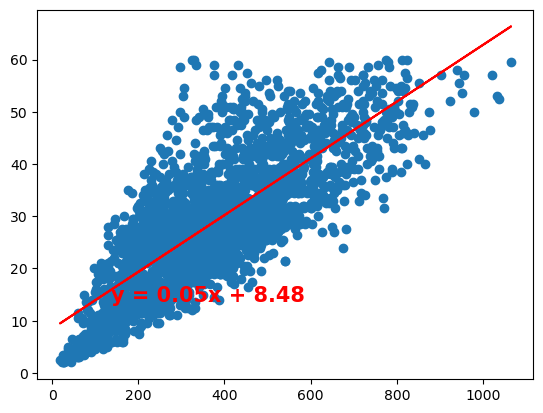

In [201]:
x_values = negative_points['Calories']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

The r-value is: 0.03479778246880041


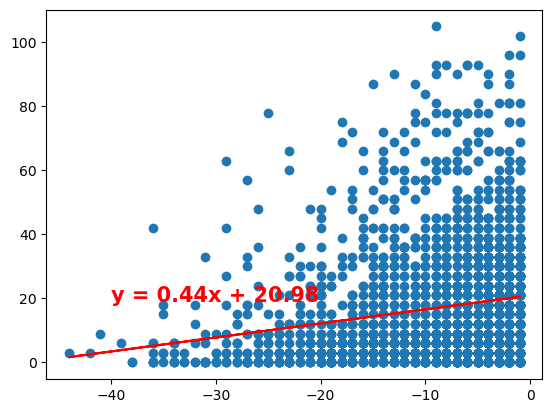

In [202]:
x_values = negative_points['wws_points']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

The r-value is: 0.3008705735678166


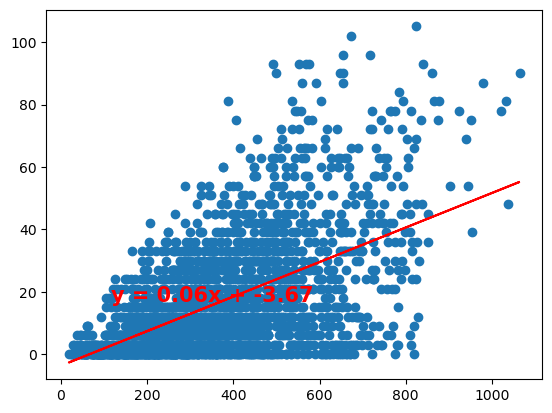

In [203]:
x_values = negative_points['Calories']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

The r-value is: 1.672809581016869e-05


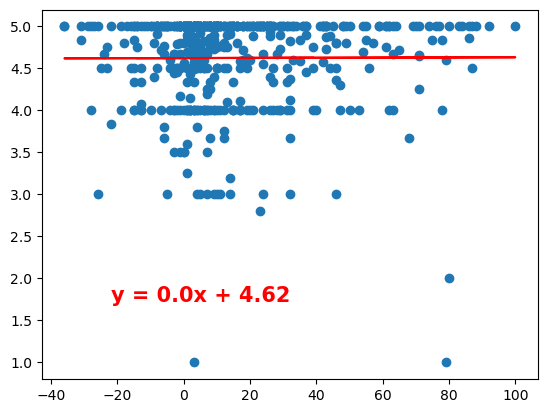

In [207]:
recipe_sample = clean_recipes.sample(n=500)
x_values = recipe_sample['wws_points']
y_values = recipe_sample['rating']

fig_test, ax_test = plt.subplots()
ax_test.scatter(x_values, y_values)
linreg_plot(ax_test, x_values, y_values, 80, 80)

In [ ]:
# CREATE A BUBBLE PLOT? Bin the WW Smart Points, use the count of each bin as the bubble size (and plot this as the 3rd dimension)

##